In [1]:
%matplotlib inline
import sys
import errno
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
import itertools
from collections import OrderedDict
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Global variables that sets the range the volatility is calculated from, and the rigidness of the changepoints

In [2]:
_volatility_range = 30
_change_flex = 0.5

Pulls the data from the appropriate url and saves it as a data frame

In [3]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [4]:
all_data = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
all_data['ds'] = pd.to_datetime(all_data['date'], unit='s')

Prints frame data

In [5]:
all_data.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
count,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,6.240000e+02,624.000000
mean,5853.638226,1.510574e+09,6067.214706,5582.499435,5845.492392,6694.531193,3.355064e+07,5825.557931
std,3964.444090,1.557598e+07,4161.017815,3712.825298,3968.666430,7144.797906,4.205410e+07,3932.029807
min,781.811601,1.483661e+09,823.498000,751.000000,781.851601,221.576031,3.275330e+05,787.033432
25%,2367.488038,1.497118e+09,2456.893125,2206.250000,2341.325000,1537.026427,7.225233e+06,2335.241590
50%,6242.500001,1.510574e+09,6386.612581,6043.376639,6230.728000,4699.861404,1.971190e+07,6247.594642
75%,8174.289888,1.524031e+09,8357.781750,7865.500000,8180.540886,8946.319371,4.226769e+07,8133.997396
max,19223.000000,1.537488e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652


Selects the appropriate data from the full frame
Pulls the dates and prices from the data and creates the log and volatility columns

In [6]:
df = all_data[['ds','close']]
df.columns = ['ds','price']
df['log'] = np.log(df['price'])
df['vol'] = df['log'].rolling(_volatility_range).std()
df.dropna();

Shows statistics for the three columns

In [7]:
df.describe()

,price,log,vol
count,624.000000,624.000000,595.000000
mean,5853.638226,8.379712,0.109633
std,3964.444090,0.844307,0.046517
min,781.811601,6.661614,0.038152
25%,2367.488038,7.769572,0.080318
50%,6242.500001,8.739136,0.100308
75%,8174.289888,9.008749,0.130526
max,19223.000000,9.863863,0.305396


Displays kurtosis for the three data sources

Kurtosis for log and vol is relatively low indicating that there aren't many extrema.

In [8]:
df.kurtosis()

price    0.262483
log     -0.946138
vol      3.928076
dtype: float64

Displays skew for the three data sources

The skew is positive meaning that that the the graph is asymmetric with a left weight

In [9]:
df.skew()

price    0.735332
log     -0.515582
vol      1.617559
dtype: float64

Generates the prophet and forecasts the specified data stream

In [10]:
m = Prophet(changepoint_prior_scale = _change_flex);
df['y'] = df['vol']
m.fit(df)

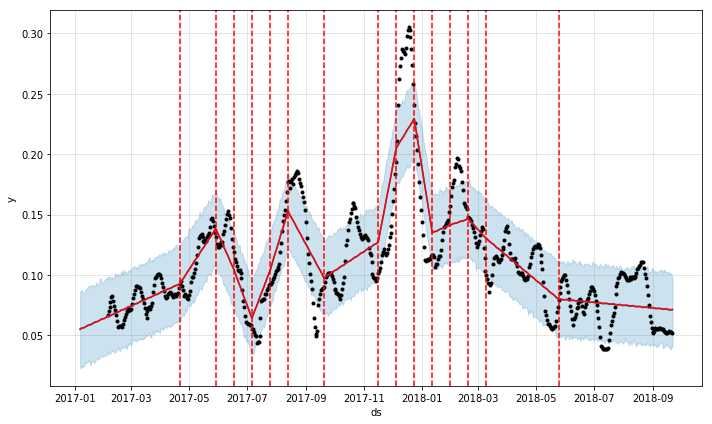

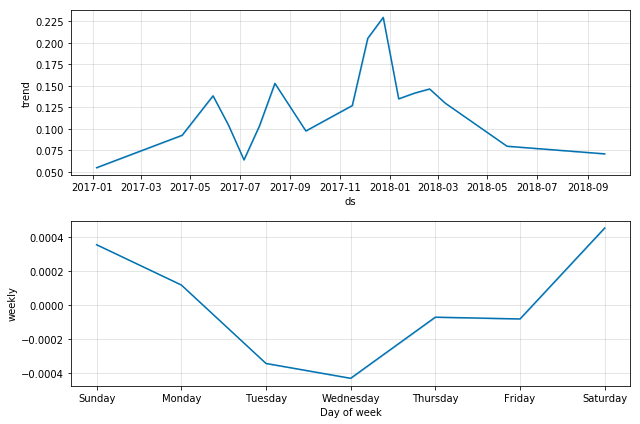

In [11]:
future = m.make_future_dataframe(periods=1)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

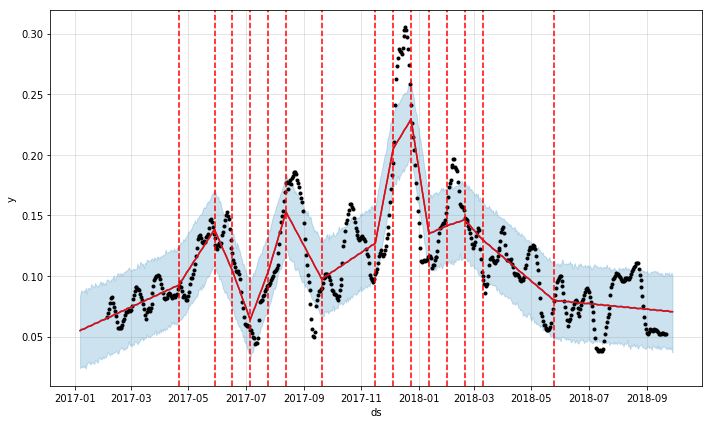

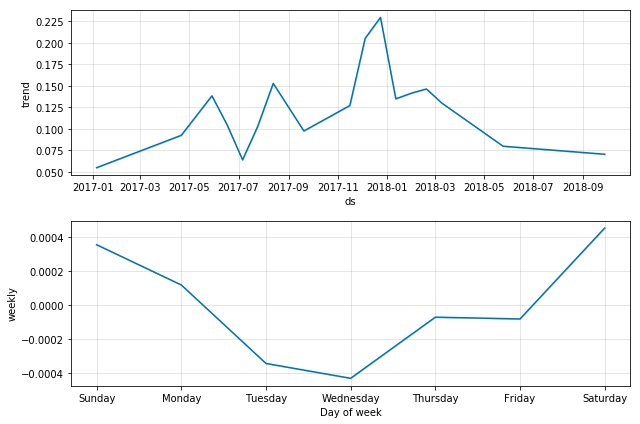

In [12]:
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

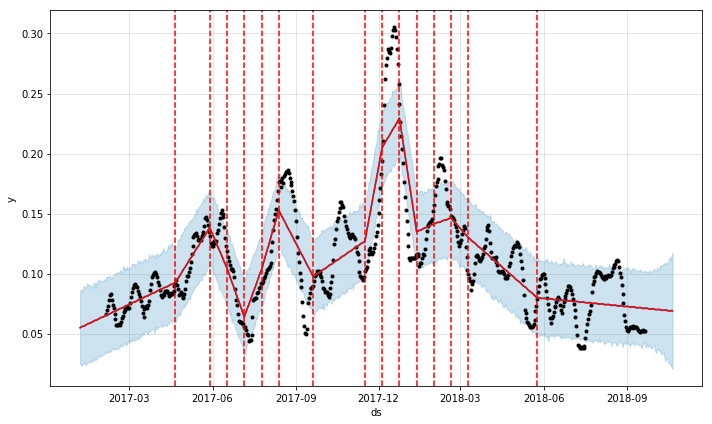

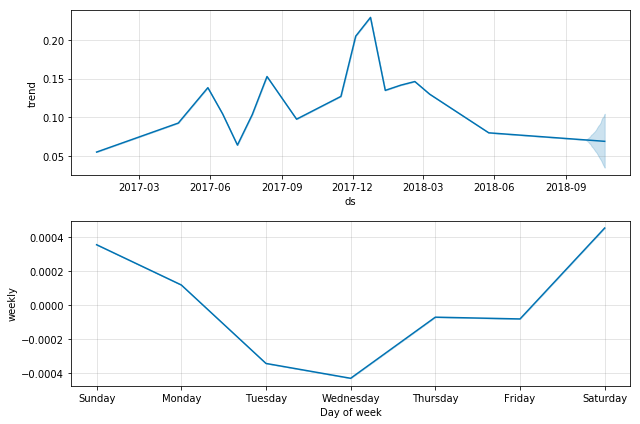

In [13]:
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

Defines method to plot the data with a red line and blue points overlayed

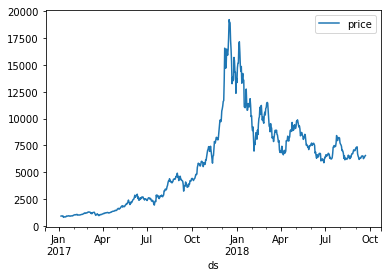

In [14]:
df.plot(x='ds', y ='price')

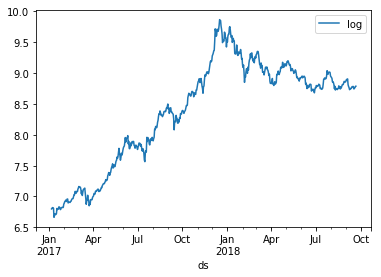

In [15]:
df.plot(x='ds', y ='log')

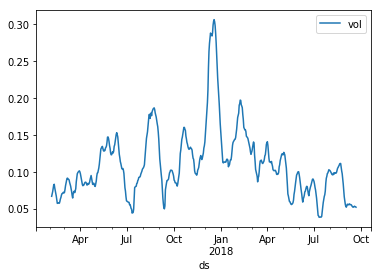

In [16]:
df.plot(x='ds', y ='vol')

Shows the trends and daily differences for 5 different weeks

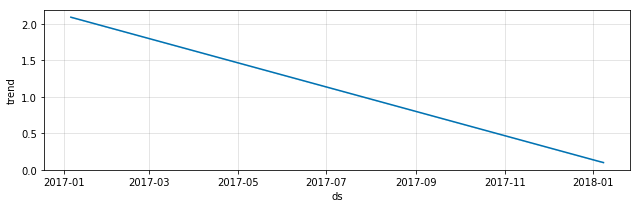

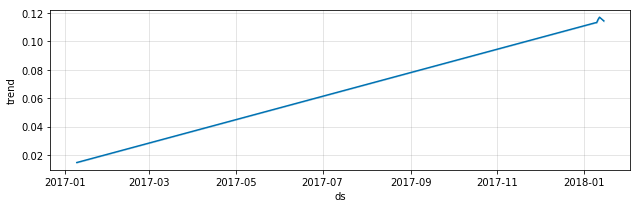

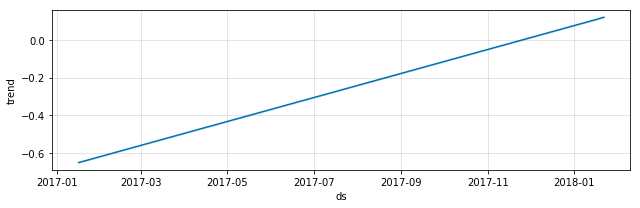

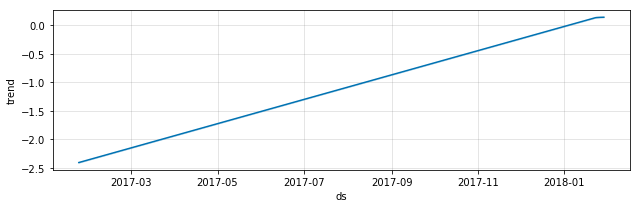

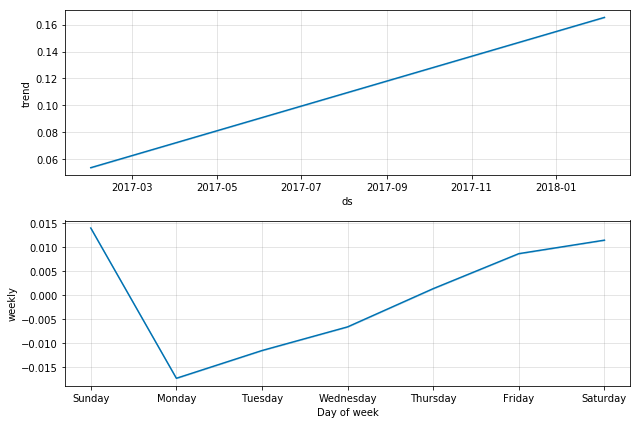

In [17]:
d = dict(tuple(df.groupby(df['ds'].dt.week)))
for i, df_week in d.items()[:5]:
    m = Prophet()
    m.fit(df_week)
    future = m.make_future_dataframe(periods=1)
    future.tail()
    forecast = m.predict(future)
    fig2 = m.plot_components(forecast)

Generates the velocity and acceleration of the volatility

In [18]:
def gen_v_a(df):
    df['v'] = df['vol'].diff()
    df['a'] = df['v'].diff()

In [19]:
gen_v_a(df)

Shows the std, mean of v and a

In [20]:
df.describe()

,price,log,vol,y,v,a
count,624.000000,624.000000,595.000000,595.000000,594.000000,593.000000
mean,5853.638226,8.379712,0.109633,0.109633,-0.000025,-0.000006
std,3964.444090,0.844307,0.046517,0.046517,0.005193,0.003389
min,781.811601,6.661614,0.038152,0.038152,-0.016926,-0.017346
25%,2367.488038,7.769572,0.080318,0.080318,-0.002833,-0.001628
50%,6242.500001,8.739136,0.100308,0.100308,0.000136,-0.000145
75%,8174.289888,9.008749,0.130526,0.130526,0.002841,0.001678
max,19223.000000,9.863863,0.305396,0.305396,0.030223,0.017957


Creates a data frame of the rolling means of df for x,v, and a

In [21]:
def gen_rolling(df):
    rolling = pd.DataFrame()
    rolling['ds'] = df['ds']
    for item in ['vol','v','a']:
        rolling[item] = df[[item]].rolling(10).mean()
        rolling[item+"std"] = rolling[[item]].rolling(10).std()
        rolling[item+"std"] = [float(i) for i in rolling[item+"std"]]
    return rolling

In [22]:
rolling = gen_rolling(df)

Plots the data versus the 10 day rolling mean of each value

In [23]:
def plot_raw(df, rolling):
    vals = df.plot(x='ds', y =['vol','v','a'], style='.', legend=False);
    rolling.plot(x='ds', y =['vol','v','a'], ax=vals, legend=True)

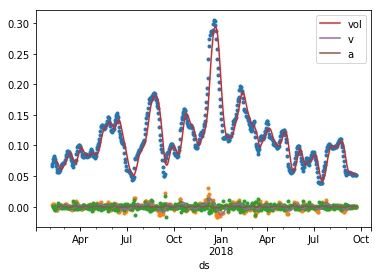

In [24]:
plot_raw(df, rolling)

Plots the data with a 95% confidence interval overlay

In [25]:
def plot_uncertain(df, rolling):
    vals = df.plot(x='ds', y =['vol','v','a'], style='.', legend=False)
    rolling.plot(x='ds', y=['vol','v','a'], yerr=2*rolling[['volstd','vstd','astd']], ax=vals, legend=True)

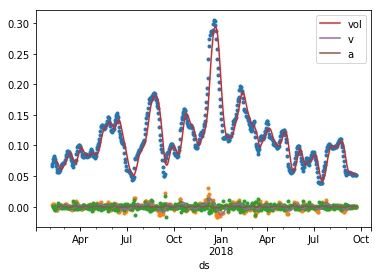

In [26]:
plot_uncertain(df, rolling)

Creates prophet for only KCA values

In [27]:
def gen_kca(df):
    m = Prophet(seasonality_mode='multiplicative')
    kca = pd.DataFrame()
    kca['ds'], kca['v'], kca['a'] = df['ds'],df['v'],df['a']
    kca['y'] = kca['v']
    m.fit(kca)
    return m

In [28]:
m = gen_kca(df)

Plots KCA results

In [29]:
def plot_m_future(p):
    future = m.make_future_dataframe(periods=p)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    fig2 = m.plot_components(forecast,uncertainty=True)

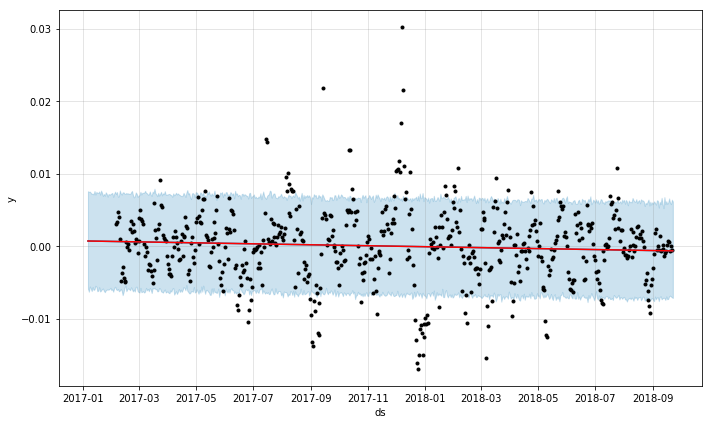

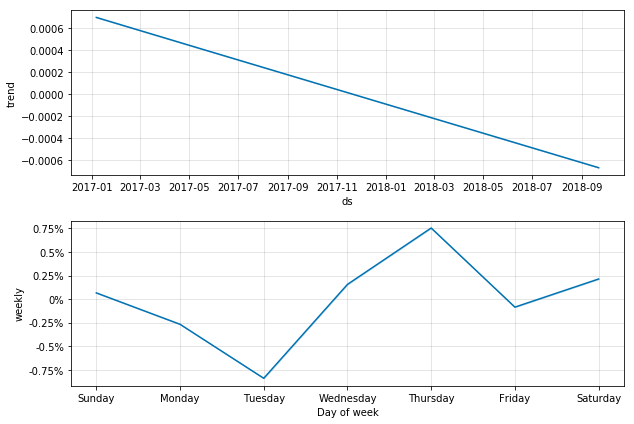

In [30]:
plot_m_future(1)

Runs the above on 6 months

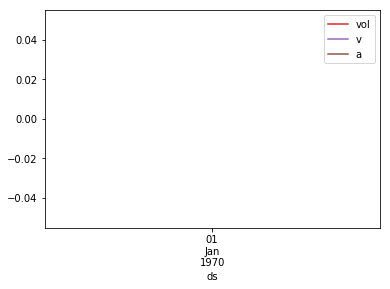

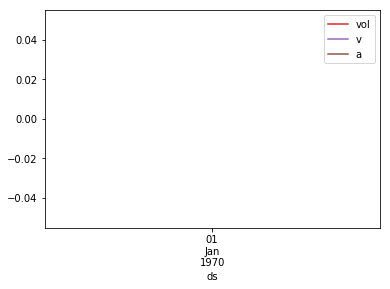

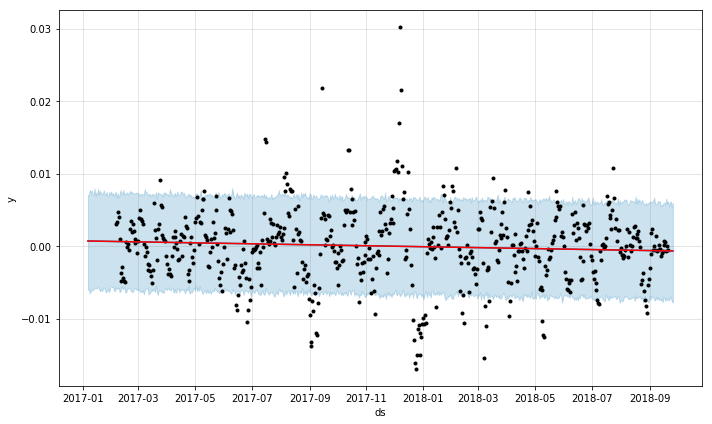

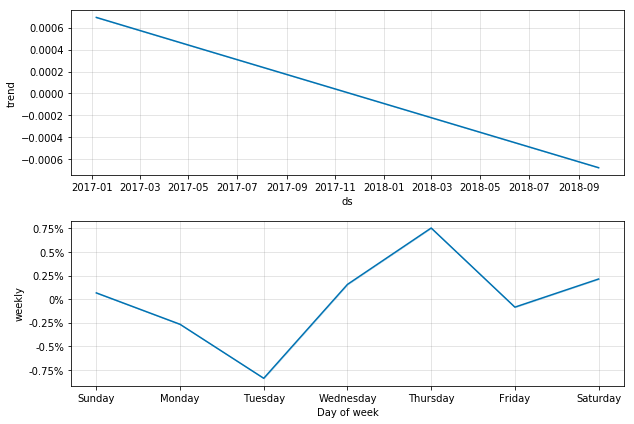

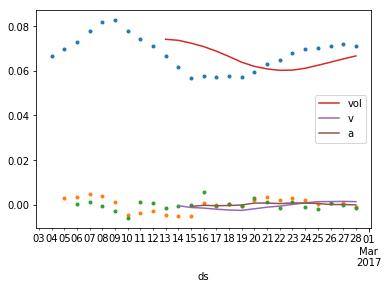

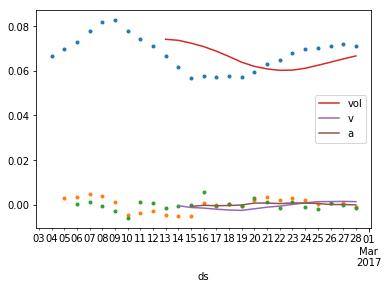

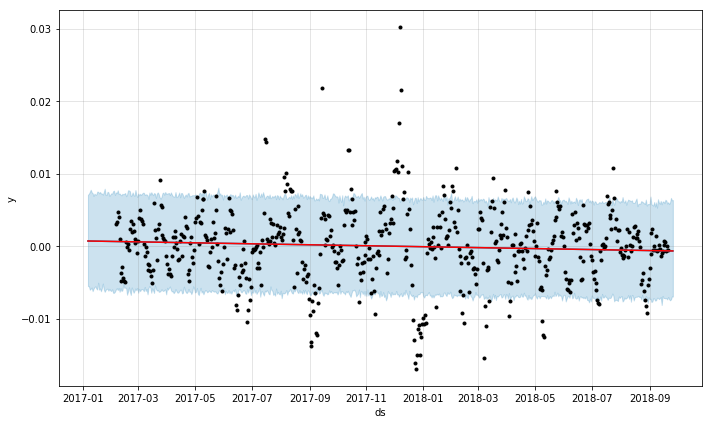

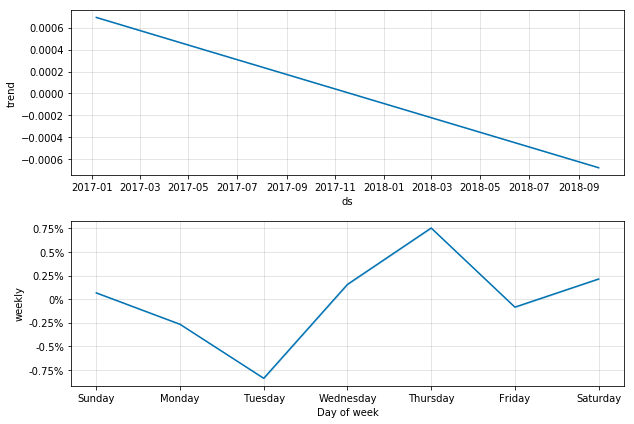

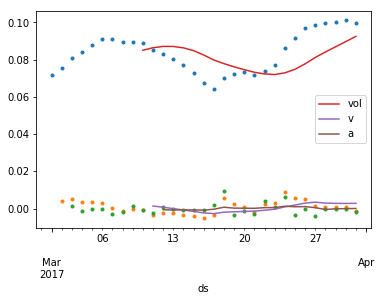

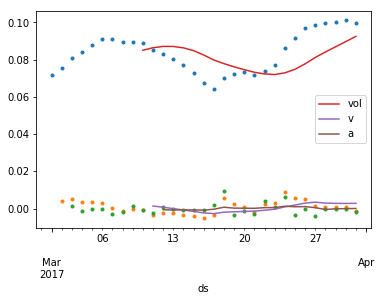

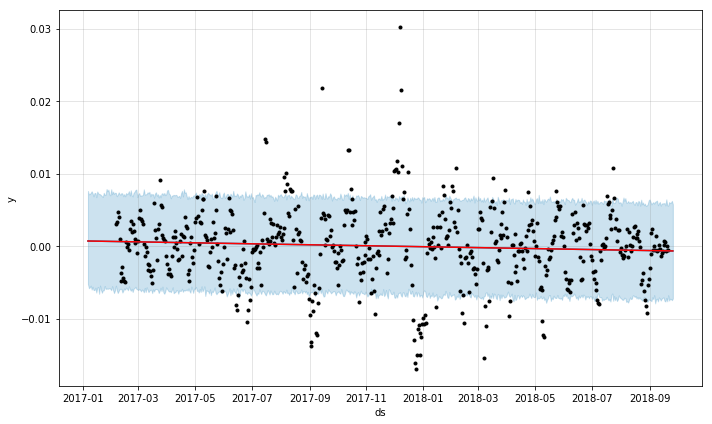

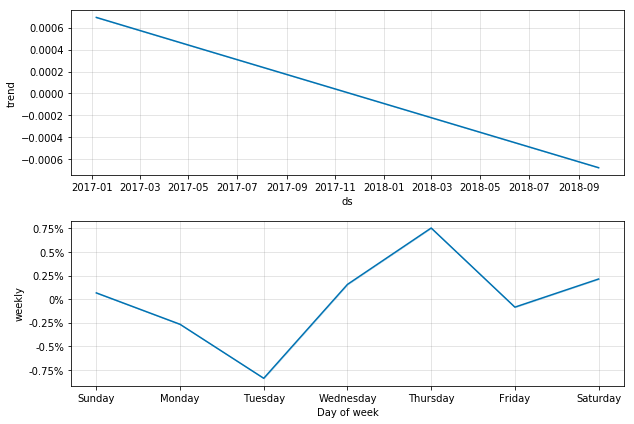

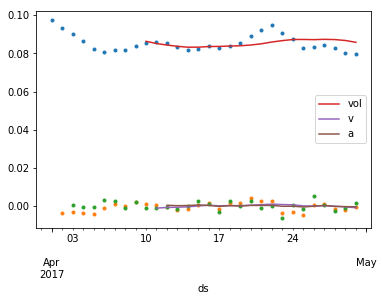

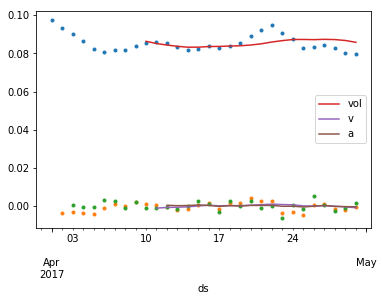

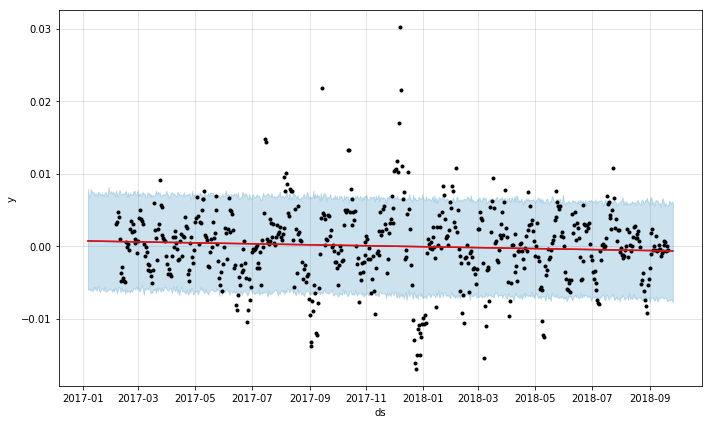

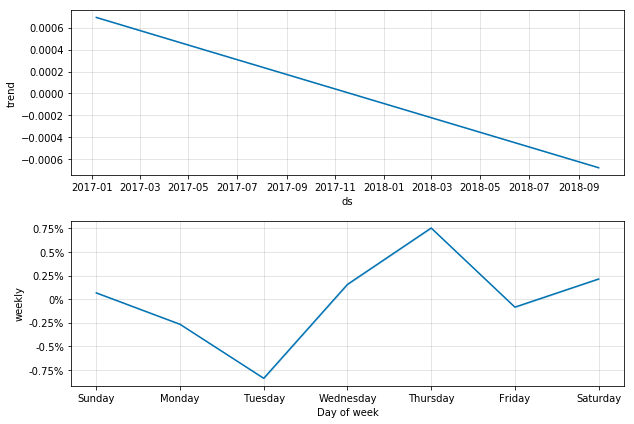

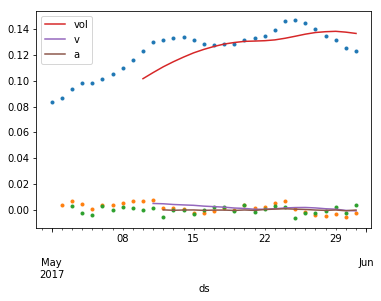

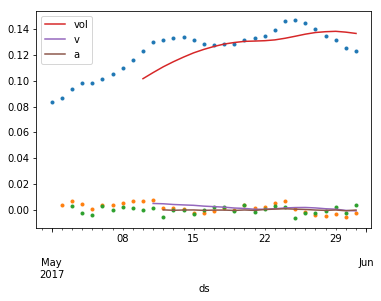

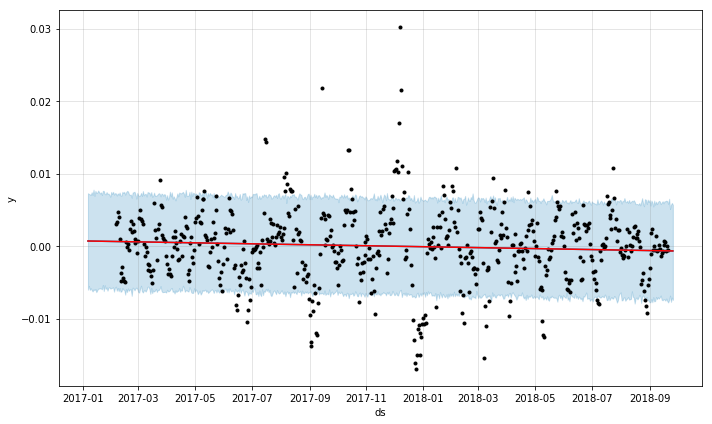

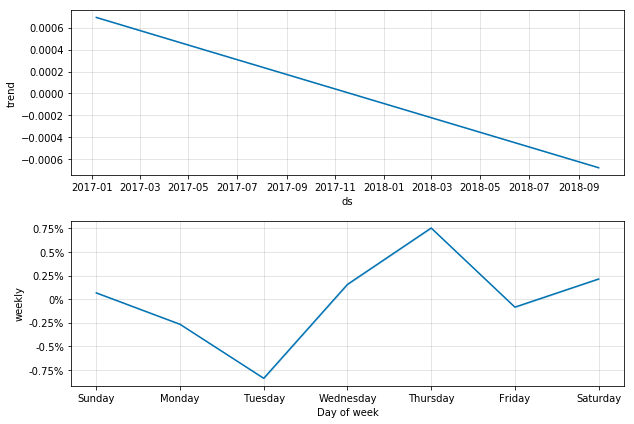

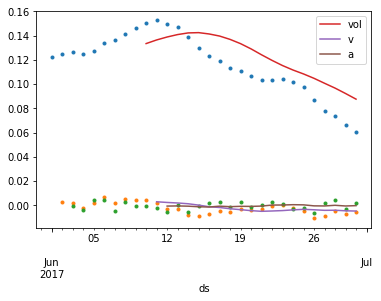

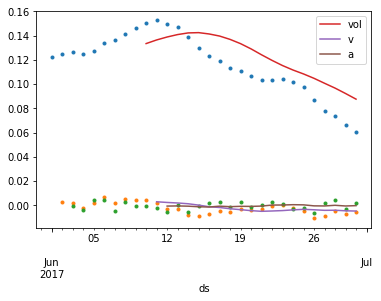

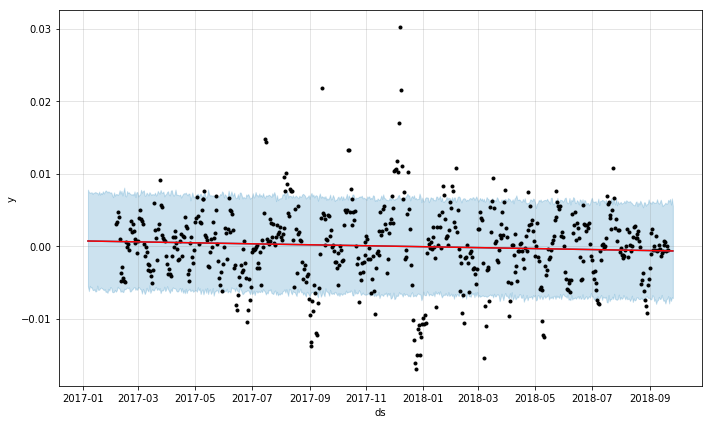

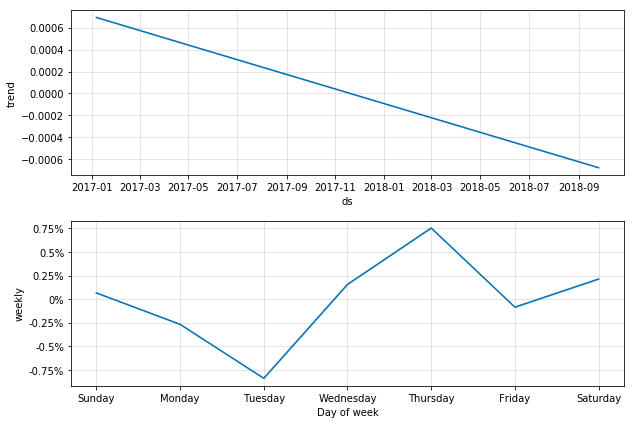

In [34]:
d = OrderedDict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items()[:6]:
    gen_v_a(df_month)
    rolling = gen_rolling(df_month)
    plot_raw(df_month, rolling)
    plot_uncertain(df_month, rolling)
    plot_m_future(5)

Runs the above on 3 bi-monthlys

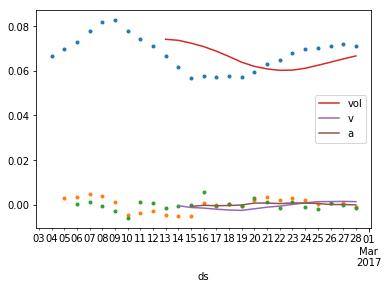

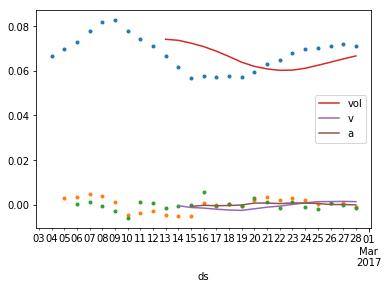

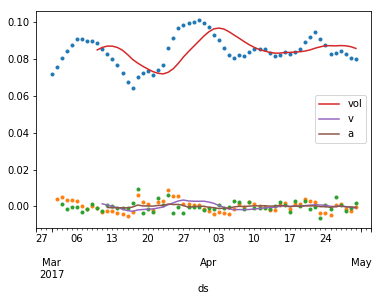

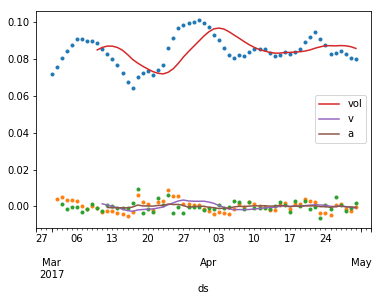

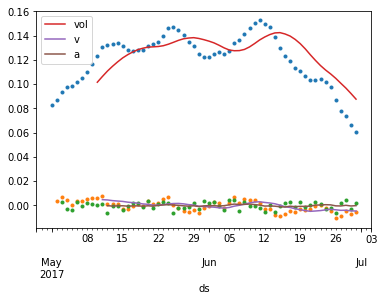

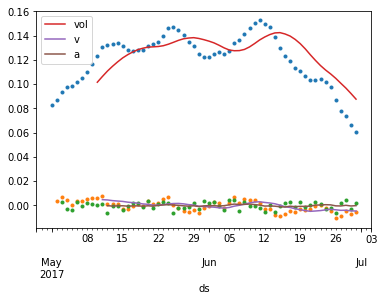

In [35]:
second = False
current_df = None
for i, df_month in d.items()[:6]:
        if second:
            second = False
            df_bimonth = pd.concat([current_df,df_month])
            gen_v_a(df_bimonth)
            rolling = gen_rolling(df_bimonth)
            plot_raw(df_bimonth, rolling)
            plot_uncertain(df_bimonth, rolling)
        else:
            second = True
            current_df = df_month

Runs the above on 2 quarters

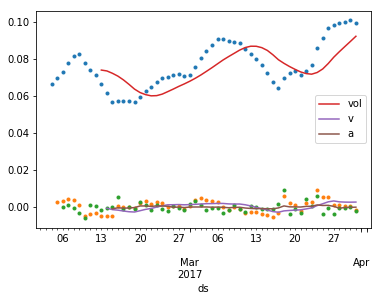

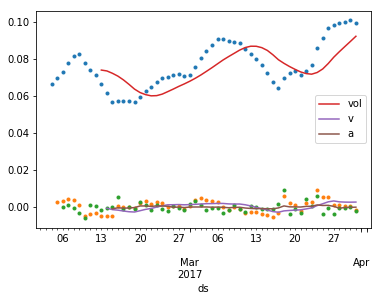

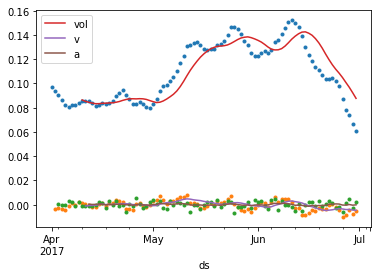

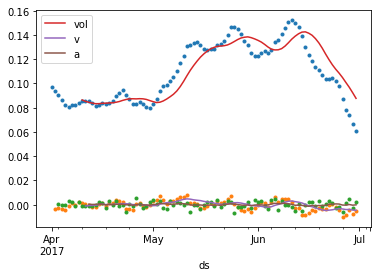

In [36]:
loop_c = 0
current_dfs = []
for i, df_month in d.items()[:6]:
        if loop_c == 2:
            df_bimonth = pd.concat([current_dfs[0], current_dfs[1], df_month])
            loop_c = 0
            current_dfs = []
            gen_v_a(df_bimonth)
            rolling = gen_rolling(df_bimonth)
            plot_raw(df_bimonth, rolling)
            plot_uncertain(df_bimonth, rolling)
        else:
            loop_c += 1
            current_dfs.append(df_month)